# Make supplementary data files
This Python Jupyter notebook makes supplementary files for antibody sets for which doing this is specified in `escape_profiles_config`:
 - raw data files
 - [dms-view](https://dms-view.github.io/) input files
 - correlations between libraries

## Set up
Import Python modules:

In [1]:
import itertools
import math
import os

from IPython.display import display, HTML

import matplotlib.pyplot as plt

import pandas as pd

from plotnine import *

import yaml

%matplotlib inline

Read the configuration file:

In [2]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Create output directory:

In [3]:
os.makedirs(config['supp_data_dir_Omicron_XBB15'], exist_ok=True)

Extract from configuration what we will use as the site- and mutation-level metrics:

In [4]:
site_metric = config['site_metric']
mut_metric = config['mut_metric']

print(f"At site level, quantifying selection by {site_metric}")
print(f"At mutation level, quantify selection by {mut_metric}")

At site level, quantifying selection by site_total_escape_frac_single_mut
At mutation level, quantify selection by mut_escape_frac_single_mut


Read escape profiles configuration and get sets for which we will be making supp data:

In [5]:
with open (config['escape_profiles_config_Omicron_XBB15']) as f:
    escape_profiles_config = yaml.safe_load(f)
    
condition_sets = {name: specs['conditions'] for name, specs in escape_profiles_config.items()
                  if 'make_supp_data' in specs and specs['make_supp_data']}

print('Making supplementary data for the following condition sets:\n  ' + '\n  '.join(condition_sets))

Making supplementary data for the following condition sets:
  VIR7229
  S2K146
  S2V29_parent
  SA55
  SA55_wide
  SA55_structure
  Omi42
  Omi42_wide
  Omi42_structure


Read the escape fractions

In [6]:
print(f"Reading escape fractions from {config['escape_fracs_Omicron_XBB15']}")
escape_fracs_all = pd.read_csv(config['escape_fracs_Omicron_XBB15'])

Reading escape fractions from results/escape_scores/escape_fracs_Omicron_XBB15.csv


Read the configuration about what data gets output on what PDBs:

In [7]:
with open (config['output_pdbs_config']) as f:
    output_pdbs_config = yaml.safe_load(f)

## Correlations between libraries
Plot correlations between libraries for mutation- and site-level escape:


Plotting correlations of mutation escape for VIR7229


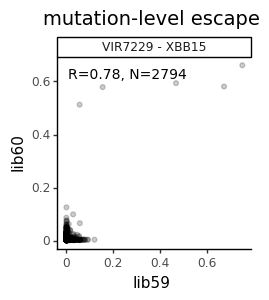

Saving plot to results/supp_data/Omicron_XBB15/VIR7229-mutation-corr.pdf

Plotting correlations of mutation escape for S2K146


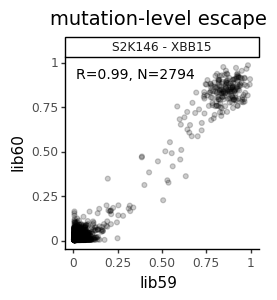

Saving plot to results/supp_data/Omicron_XBB15/S2K146-mutation-corr.pdf

Plotting correlations of mutation escape for S2V29_parent


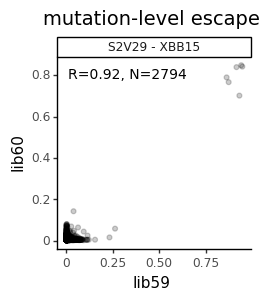

Saving plot to results/supp_data/Omicron_XBB15/S2V29_parent-mutation-corr.pdf

Plotting correlations of mutation escape for SA55


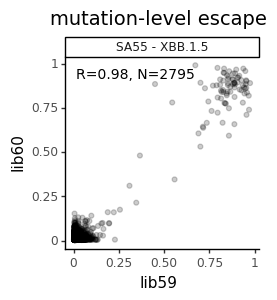

Saving plot to results/supp_data/Omicron_XBB15/SA55-mutation-corr.pdf

Plotting correlations of mutation escape for SA55_wide


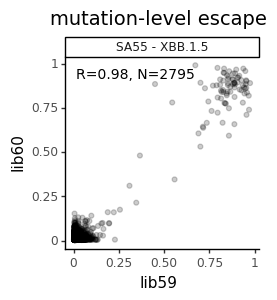

Saving plot to results/supp_data/Omicron_XBB15/SA55_wide-mutation-corr.pdf

Plotting correlations of mutation escape for SA55_structure


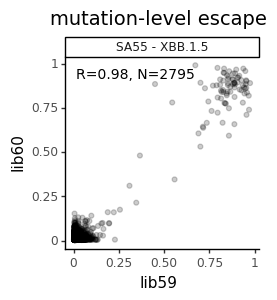

Saving plot to results/supp_data/Omicron_XBB15/SA55_structure-mutation-corr.pdf

Plotting correlations of mutation escape for Omi42


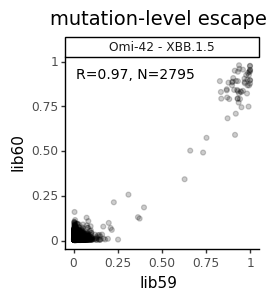

Saving plot to results/supp_data/Omicron_XBB15/Omi42-mutation-corr.pdf

Plotting correlations of mutation escape for Omi42_wide


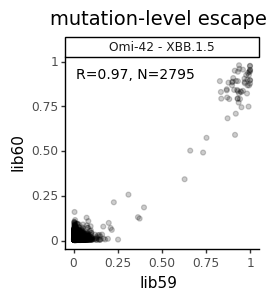

Saving plot to results/supp_data/Omicron_XBB15/Omi42_wide-mutation-corr.pdf

Plotting correlations of mutation escape for Omi42_structure


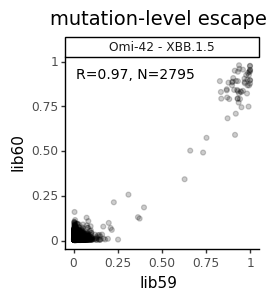

Saving plot to results/supp_data/Omicron_XBB15/Omi42_structure-mutation-corr.pdf

Plotting correlations of site escape for VIR7229


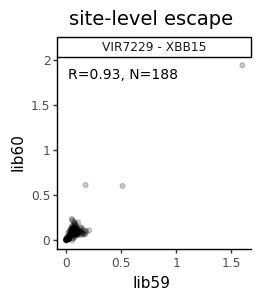

Saving plot to results/supp_data/Omicron_XBB15/VIR7229-site-corr.pdf

Plotting correlations of site escape for S2K146


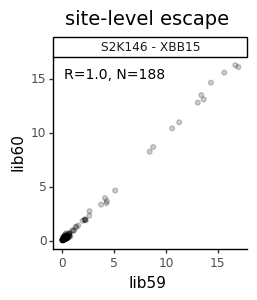

Saving plot to results/supp_data/Omicron_XBB15/S2K146-site-corr.pdf

Plotting correlations of site escape for S2V29_parent


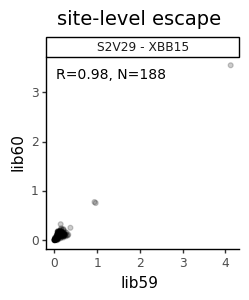

Saving plot to results/supp_data/Omicron_XBB15/S2V29_parent-site-corr.pdf

Plotting correlations of site escape for SA55


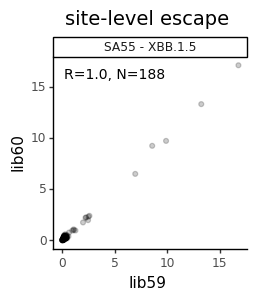

Saving plot to results/supp_data/Omicron_XBB15/SA55-site-corr.pdf

Plotting correlations of site escape for SA55_wide


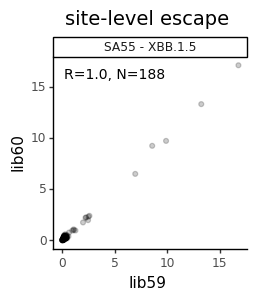

Saving plot to results/supp_data/Omicron_XBB15/SA55_wide-site-corr.pdf

Plotting correlations of site escape for SA55_structure


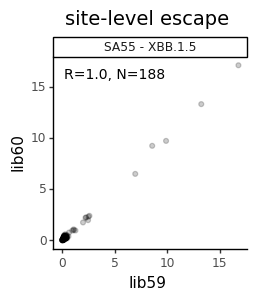

Saving plot to results/supp_data/Omicron_XBB15/SA55_structure-site-corr.pdf

Plotting correlations of site escape for Omi42


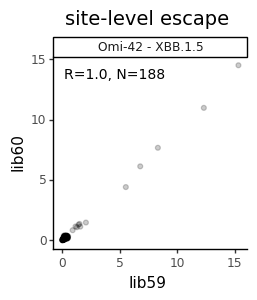

Saving plot to results/supp_data/Omicron_XBB15/Omi42-site-corr.pdf

Plotting correlations of site escape for Omi42_wide


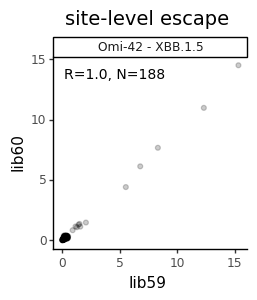

Saving plot to results/supp_data/Omicron_XBB15/Omi42_wide-site-corr.pdf

Plotting correlations of site escape for Omi42_structure


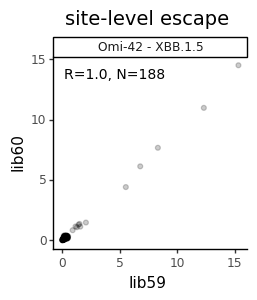

Saving plot to results/supp_data/Omicron_XBB15/Omi42_structure-site-corr.pdf


In [8]:
libraries = [lib for lib in escape_fracs_all['library'].unique() if lib != "average"]
assert len(libraries) == 2, 'plot only makes sense if 2 libraries'

for metric_type, (set_name, condition_set) in itertools.product(['mutation', 'site'],
                                                                condition_sets.items()):
    
    print(f"\nPlotting correlations of {metric_type} escape for {set_name}")
    
    if metric_type == 'mutation':
        metric = mut_metric
        pivot_index = ['selection', 'site', 'mutation']
    elif metric_type == 'site':
        metric = site_metric
        pivot_index = ['selection', 'site']
    else:
        raise ValueError(f"invalid `metric_type` {metric_type}")

    # wide data frame with each library's score in a different column
    df_wide = (
        escape_fracs_all
        .query('library != "average"')
        .query('selection in @condition_set')
        .assign(selection=lambda x: x['selection'].map(condition_set))
        # need to drop duplicate columns if using site metric
        [['library', metric] + pivot_index]
        .drop_duplicates()
        # now make columns for each library, only keep mutants with scores for both libs
        .pivot_table(index=pivot_index,
                     columns='library',
                     values=metric)
        .reset_index()
        .dropna(axis=0)
        )

    # correlations between libraries
    corrs = (
        df_wide
        .groupby('selection')
        [libraries]
        .corr(method='pearson')
        .reset_index()
        .query('library == @libraries[0]')
        .assign(correlation=lambda x: 'R=' + x[libraries[1]].round(2).astype(str))
        [['selection', 'correlation']]
        # add number of mutations measured
        .merge(df_wide
               .groupby('selection')
               .size()
               .rename('n')
               .reset_index()
               )
        .assign(correlation=lambda x: x['correlation'] + ', N=' + x['n'].astype(str))
        )

    # plot correlations
    nfacets = df_wide['selection'].nunique()
    ncol = min(nfacets, 5)
    nrow = math.ceil(nfacets / ncol)
    xmin = df_wide[libraries[0]].min()
    xspan = df_wide[libraries[0]].max() - xmin
    ymin = df_wide[libraries[1]].min()
    yspan = df_wide[libraries[1]].max() - ymin
    p = (ggplot(df_wide) +
         aes(libraries[0], libraries[1]) +
         geom_point(alpha=0.2, color='black') +
         geom_text(mapping=aes(label='correlation'),
                   data=corrs,
                   x=0.01 * xspan + xmin,
                   y=0.99 * yspan + ymin,
                   size=10,
                   ha='left',
                   va='top',
                   ) +
         facet_wrap('~ selection', ncol=ncol) +
         theme_classic() +
         theme(figure_size=(2.5 * ncol, 2.5 * nrow),
               plot_title=element_text(size=14)) +
         ggtitle(f"{metric_type}-level escape")
         )

    fig = p.draw()
    display(fig)
    plotfile = os.path.join(config['supp_data_dir_Omicron_XBB15'],
                            f"{set_name}-{metric_type}-corr.pdf")
    print(f"Saving plot to {plotfile}")
    p.save(plotfile, verbose=False)
    plt.close(fig)

## Raw data files
Get the "raw data" for the effects of each mutation on antibody escape.
This has just the columns of most interest for the average of the two libraries, renamed in a sensible way:

In [9]:
raw_data = (
    escape_fracs_all
    .query('library == "average"')
    .drop(columns=['library'])
    .rename(columns={mut_metric: 'mut_escape',
                     site_metric: 'site_total_escape'})
    [['condition', 'site', 'label_site', 'wildtype', 'mutation', 'protein_chain',
      'protein_site', 'mut_escape', 'site_total_escape']]
    .assign(site_max_escape=lambda x: x.groupby(['condition', 'site'])['mut_escape'].transform('max'))
    )

Now write the raw data for each condition set:

In [10]:
for set_name, condition_set in condition_sets.items():
    print(f"\nRaw data for {set_name}:")
    df = (raw_data
          .query('condition in @condition_set')
          .assign(condition=lambda x: x['condition'].map(condition_set))
          [['condition', 'label_site', 'wildtype', 'mutation', 'mut_escape',
            'site_total_escape', 'site_max_escape']]
          .rename(columns={'label_site': 'site'})
          )
    #display(HTML(df.head().to_html(index=False)))
    csv_file = os.path.join(config['supp_data_dir_Omicron_XBB15'], f"{set_name}_raw_data.csv")
    print(f"Writing to {csv_file}")
    df.to_csv(csv_file, index=False, float_format='%.4g')


Raw data for VIR7229:
Writing to results/supp_data/Omicron_XBB15/VIR7229_raw_data.csv

Raw data for S2K146:
Writing to results/supp_data/Omicron_XBB15/S2K146_raw_data.csv

Raw data for S2V29_parent:
Writing to results/supp_data/Omicron_XBB15/S2V29_parent_raw_data.csv

Raw data for SA55:
Writing to results/supp_data/Omicron_XBB15/SA55_raw_data.csv

Raw data for SA55_wide:
Writing to results/supp_data/Omicron_XBB15/SA55_wide_raw_data.csv

Raw data for SA55_structure:
Writing to results/supp_data/Omicron_XBB15/SA55_structure_raw_data.csv

Raw data for Omi42:
Writing to results/supp_data/Omicron_XBB15/Omi42_raw_data.csv

Raw data for Omi42_wide:
Writing to results/supp_data/Omicron_XBB15/Omi42_wide_raw_data.csv

Raw data for Omi42_structure:
Writing to results/supp_data/Omicron_XBB15/Omi42_structure_raw_data.csv


## Data for `dms-view`:
Now we write the data in a format for display by [dms-view](https://dms-view.github.io/docs/dataupload) with several different possible mutation-level escape color schemes and also allowing options to visualize directly the deep mutational scanning data.
We write such a file for each condition set for the PDBs specified in `output_pdbs_config`.

First, create the different color schemes for the mutation-level escape.
The first step is to read these color schemes:

In [11]:
print(f"Reading DMS color schemes from {config['escape_profiles_dms_colors_Omicron_XBB15']}")

dms_colors = (
    pd.read_csv(config['escape_profiles_dms_colors_Omicron_XBB15'])
    .drop(columns=['bind', 'expr'])
    .rename(columns={'site': 'label_site'})
    .rename(columns={'bind_color': 'color ACE2 bind',
                     'expr_color': 'color RBD expr'})
    # add color schemes by functional group and all gray
    .assign(**{'color gray': '#696969',
               'color func group': 'functional'})
    )

Reading DMS color schemes from results/escape_profiles/Omicron_XBB15/escape_profiles_dms_colors.csv


Now write a [dms-view](https://dms-view.github.io/docs/dataupload) input file that allows different mutation-level coloring schemes:

In [12]:
dms_view_df = (
    pd.concat([raw_data.merge(dms_colors[['label_site', 'mutation', color]],
                              how='left',
                              validate='many_to_one')
                       .rename(columns={color: 'color_for_mutation',
                                        'mut_escape': 'mut_escape ' + color})
               for color in dms_colors.drop(columns=['label_site', 'mutation']).columns.tolist()
               ])
    .rename(columns={'site_max_escape': 'site_max escape',
                     'site_total_escape': 'site_total escape'})
    .drop(columns='protein_chain')
    )

display(HTML(dms_view_df.head().to_html(index=False)))

condition,site,label_site,wildtype,mutation,protein_site,mut_escape color ACE2 bind,site_total escape,site_max escape,color_for_mutation,mut_escape color RBD expr,mut_escape color gray,mut_escape color func group
Omi42_156,1,331,N,-,331,0.007279,0.3294,0.07648,#662505,NaN,NaN,NaN
Omi42_156,1,331,N,A,331,0.012750,0.3294,0.07648,#662505,NaN,NaN,NaN
Omi42_156,1,331,N,C,331,0.015820,0.3294,0.07648,#993403,NaN,NaN,NaN
Omi42_156,1,331,N,D,331,0.006378,0.3294,0.07648,#662505,NaN,NaN,NaN
Omi42_156,1,331,N,E,331,0.033550,0.3294,0.07648,#662505,NaN,NaN,NaN


Finally, write `dms-view` input files for each condition set:

In [13]:
for set_name, condition_set in condition_sets.items():
    
    for pdb_name, pdb_specs in output_pdbs_config.items():
        
        # get all conditions for this set to be written to this PDB
        if isinstance(pdb_specs['conditions'], str) and pdb_specs['conditions'].upper() == 'ALL':
            pdb_conditions = condition_set
        else:
            assert isinstance(pdb_specs['conditions'], list)
            pdb_conditions = [condition for condition in condition_set
                              if condition in pdb_specs['conditions']]
        if not pdb_conditions:
            continue
            
        df = (dms_view_df
              .query('condition in @pdb_conditions')
              .assign(condition=lambda x: x['condition'].map(condition_set))  # re-name to shorter names
              )
        
        # assign all relevant protein chains
        cols = df.columns.tolist()
        i = cols.index('protein_site')  # add protein chain column here
        newcols = cols[: i] + ['protein_chain'] + cols[i: ]
        chains = ' '.join(pdb_specs['chains'])
        df = df.assign(protein_chain=chains)[newcols]
   
        csv_file = os.path.join(config['supp_data_dir_Omicron_XBB15'], f"{set_name}_{pdb_name}_dms-view_data.csv")
        print(f"Writing `dms-view` input file for {set_name} mapped to PDB {pdb_name} to {csv_file}")
        df.to_csv(csv_file, index=False, float_format='%.4g')

Writing `dms-view` input file for VIR7229 mapped to PDB 6m0j to results/supp_data/Omicron_XBB15/VIR7229_6m0j_dms-view_data.csv
Writing `dms-view` input file for S2K146 mapped to PDB 6m0j to results/supp_data/Omicron_XBB15/S2K146_6m0j_dms-view_data.csv
Writing `dms-view` input file for S2V29_parent mapped to PDB 6m0j to results/supp_data/Omicron_XBB15/S2V29_parent_6m0j_dms-view_data.csv
Writing `dms-view` input file for SA55 mapped to PDB 6m0j to results/supp_data/Omicron_XBB15/SA55_6m0j_dms-view_data.csv
Writing `dms-view` input file for SA55_wide mapped to PDB 6m0j to results/supp_data/Omicron_XBB15/SA55_wide_6m0j_dms-view_data.csv
Writing `dms-view` input file for SA55_structure mapped to PDB 6m0j to results/supp_data/Omicron_XBB15/SA55_structure_6m0j_dms-view_data.csv
Writing `dms-view` input file for Omi42 mapped to PDB 6m0j to results/supp_data/Omicron_XBB15/Omi42_6m0j_dms-view_data.csv
Writing `dms-view` input file for Omi42_wide mapped to PDB 6m0j to results/supp_data/Omicron_XB